In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [2]:
train_zip = "data/train.zip"
with ZipFile(train_zip, 'r') as zip_: 
    zip_.extractall('.')
train_mask_zip = "data/train_masks.zip"
with ZipFile(train_mask_zip, 'r') as zip_: 
    zip_.extractall('.')
car_ids = []
paths = []
for dirname, _, filenames in os.walk('train'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        car_id = filename.split(".")[0]
        car_ids.append(car_id)


In [3]:
d = {"id": car_ids, "car_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df
car_ids = []
mask_path = []
for dirname, _, filenames in os.walk('train_masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        car_id = filename.split(".")[0]
        car_id = car_id.split("_mask")[0]
        car_ids.append(car_id)

In [4]:
        
d = {"id": car_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df
df["mask_path"] = mask_df["mask_path"]
df


,car_path,mask_path
id,,
00087a6bd4dc_01,train\00087a6bd4dc_01.jpg,train_masks\00087a6bd4dc_01_mask.gif
00087a6bd4dc_02,train\00087a6bd4dc_02.jpg,train_masks\00087a6bd4dc_02_mask.gif
00087a6bd4dc_03,train\00087a6bd4dc_03.jpg,train_masks\00087a6bd4dc_03_mask.gif
00087a6bd4dc_04,train\00087a6bd4dc_04.jpg,train_masks\00087a6bd4dc_04_mask.gif
00087a6bd4dc_05,train\00087a6bd4dc_05.jpg,train_masks\00087a6bd4dc_05_mask.gif
...,...,...
fff9b3a5373f_12,train\fff9b3a5373f_12.jpg,train_masks\fff9b3a5373f_12_mask.gif
fff9b3a5373f_13,train\fff9b3a5373f_13.jpg,train_masks\fff9b3a5373f_13_mask.gif
fff9b3a5373f_14,train\fff9b3a5373f_14.jpg,train_masks\fff9b3a5373f_14_mask.gif


In [5]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)
    return car_img, mask_img


In [6]:
def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

In [7]:
def create_dataset(df, train = False):
    ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
    ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    if train:
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)
    return ds

In [8]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

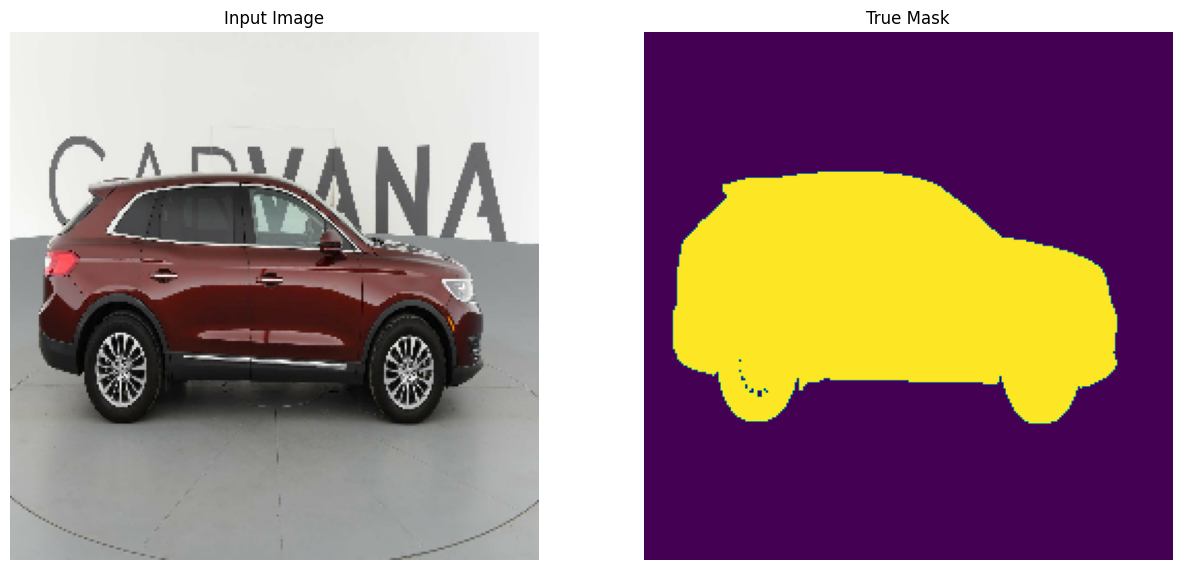

In [10]:
for i in range(2):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])


In [11]:
# Model
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

C:\Users\kumar\AppData\Local\Temp\ipykernel_13252\4031359599.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)


In [12]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]


In [13]:
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False


In [15]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(tf.keras.layers.LayerNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result
    

In [16]:

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
# Train the Model

def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)


In [19]:
def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

In [21]:
model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

In [22]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

In [23]:
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [24]:
def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


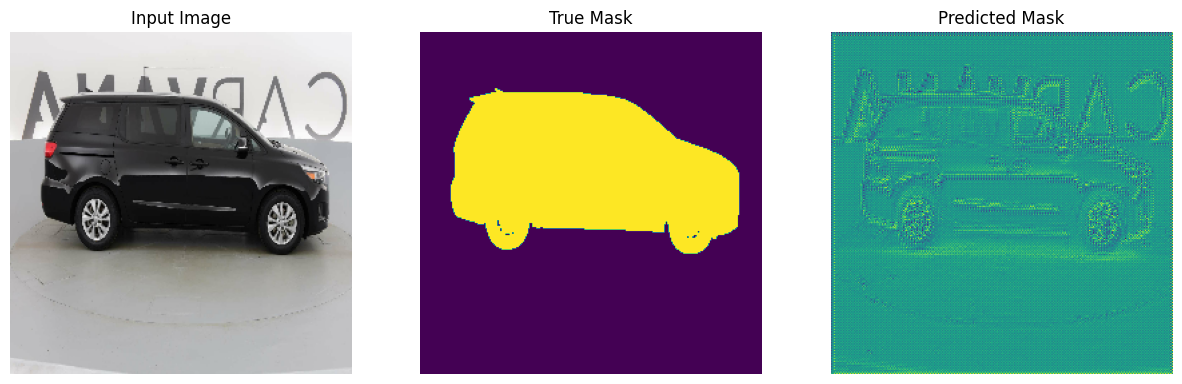

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 128, 128, │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16, 16,    │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64, 64,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 128, 128,  │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 256, 256,  │      1,441 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,501,345 (24.80 MB)

 Trainable params: 4,657,441 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [25]:
    
show_predictions(sample_image, sample_mask)
model.summary()

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)


In [ ]:
EPOCHS = 15
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

In [ ]:
# Save the trained model
model.save('unet_model.h5')

# Save the model weights separately
model.save_weights('unet_model.weights.h5')